# CH-04 讓 AI 計算技術指標及資料視覺化

## 4-1 技術指標公式太複雜？讓 AI 自動化計算

### 1️⃣ 安裝及匯入套件

In [1]:
!pip install openai
!pip install yfinance==0.2.38
from  openai import OpenAI, OpenAIError # 串接 OpenAI API
import yfinance as yf
import pandas as pd # 資料處理套件
import datetime as dt # 時間套件

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


### 2️⃣ 取得股票資料

In [2]:
# 輸入股票代號
stock_id = "2330.tw"
# 抓取半年資料
end = dt.date.today() # 資料結束時間
start = end - dt.timedelta(days=180) # 資料開始時間
df = yf.download(stock_id, start=start, end=end).reset_index()

print(df)

[*********************100%%**********************]  1 of 1 completed

          Date    Open    High     Low   Close    Adj Close    Volume
0   2024-08-20   977.0   977.0   968.0   973.0   964.972473  24039959
1   2024-08-21   961.0   964.0   956.0   958.0   950.096191  29758188
2   2024-08-22   958.0   964.0   948.0   951.0   943.153992  24349754
3   2024-08-23   944.0   952.0   939.0   949.0   941.170532  27592153
4   2024-08-26   957.0   961.0   945.0   950.0   942.162231  25057581
..         ...     ...     ...     ...     ...          ...       ...
111 2025-02-10  1125.0  1125.0  1095.0  1105.0  1105.000000  28527108
112 2025-02-11  1110.0  1115.0  1100.0  1110.0  1110.000000  18898928
113 2025-02-12  1110.0  1115.0  1100.0  1100.0  1100.000000  24172954
114 2025-02-13  1090.0  1095.0  1080.0  1090.0  1090.000000  33210403
115 2025-02-14  1065.0  1070.0  1060.0  1060.0  1060.000000  64486940

[116 rows x 7 columns]


### 3️⃣ 輸入 GEMINI API KEY

In [6]:
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('GEMINI_API_KEY'),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

### 4️⃣ 創建 Gemini 2.0 Flash 模型函式

In [9]:
def get_reply(messages):
  try:
    response = client.chat.completions.create(model="gemini-2.0-flash",
                          messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply

# 設定 AI 角色, 使其依據使用者需求進行 df 處理
def ai_helper(df, user_msg):

  msg = [{
    "role":
    "system",
    "content":
    f"As a professional code generation robot, \
      I require your assistance in generating Python code \
      based on specific user requirements. To proceed, \
      I will provide you with a dataframe (df) that follows the \
      format {df.columns}. Your task is to carefully analyze the \
      user's requirements and generate the Python code \
      accordingly.Please note that your response should solely \
      consist of the code itself, \
      and no additional information should be included."
  }, {
    "role":
    "user",
    "content":
    f"The user requirement:{user_msg} \n\
       Your task is to develop a Python function named \
      'calculate(df)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {df.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(df)' function \
      and exclude any unrelated content."
  }]

  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```", "")
  cleaned_code = cleaned_code.replace("python", "")

  return cleaned_code

### 讓 AI 自動生成技術指標程式碼

### 5️⃣ 計算移動平均線

In [10]:
code_str = ai_helper(df, "計算8日MA與13日MA ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the 8-day and 13-day moving averages of the 'Close' price.

    Args:
        df (pd.DataFrame): A DataFrame with a 'Close' column.
                           The DataFrame should have the following columns:
                           Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

    Returns:
        pd.DataFrame: The input DataFrame with two new columns, 'MA8' and 'MA13',
                      containing the 8-day and 13-day moving averages of the 'Close' price, respectively.
    """

    df['MA8'] = df['Close'].rolling(window=8).mean()
    df['MA13'] = df['Close'].rolling(window=13).mean()
    return df



,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13
111,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231
112,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692
113,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000
114,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154
115,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769


### 6️⃣ 計算 MACD

In [11]:
code_str = ai_helper(df, "先計算 EMA 再計算 MACD, 欄位名稱用 MACD_Histogram 命名")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the Exponential Moving Average (EMA) and Moving Average Convergence Divergence (MACD)
    for a given dataframe containing stock price data.

    Args:
        df (pd.DataFrame): A pandas DataFrame with columns including 'Close'.

    Returns:
        pd.DataFrame: The input DataFrame with added 'MACD_Histogram' column.
    """
    # Calculate EMA12
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()

    # Calculate EMA26
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

    # Calculate MACD Line
    df['MACD'] = df['EMA12'] - df['EMA26']

    # Calculate Signal Line (EMA9 of MACD)
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate MACD Histogram
    df['MACD_Histogram'] = df['MACD'] - df['Signal']

    return df



,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram
111,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231,1106.737245,1097.339234,9.398011,10.055749,-0.657738
112,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692,1107.239207,1098.277068,8.962139,9.837027,-0.874888
113,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000,1106.125483,1098.404693,7.720790,9.413780,-1.692989
114,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154,1103.644639,1097.782123,5.862517,8.703527,-2.841010
115,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516


### 7️⃣ 計算 RSI

In [12]:
code_str = ai_helper(df, "計算 RSI ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the Relative Strength Index (RSI) for a given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing stock data with a 'Close' column.

    Returns:
        pd.DataFrame: DataFrame with an additional 'RSI' column.
    """

    delta = df['Close'].diff()
    delta = delta[1:]  # Remove the first row (NaN due to diff)

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    window = 14
    avg_gain = up.rolling(window=window, min_periods=window).mean()
    avg_loss = abs(down.rolling(window=window, min_periods=window).mean())

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Align RSI with the original DataFrame
    rsi_series = pd.Series(rsi, index=delta.index)
    df['RSI'] = rsi_series

    return df



,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI
111,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231,1106.737245,1097.339234,9.398011,10.055749,-0.657738,50.909091
112,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692,1107.239207,1098.277068,8.962139,9.837027,-0.874888,56.862745
113,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000,1106.125483,1098.404693,7.720790,9.413780,-1.692989,52.000000
114,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154,1103.644639,1097.782123,5.862517,8.703527,-2.841010,55.319149
115,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516,40.000000


### 8️⃣ 計算布林通道

In [13]:
code_str = ai_helper(df, "請計算1.5個標準差的布林通道, 欄位以 Upper_Band 和 Lower_Band 命名")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    df['Upper_Band'] = df['MA13'] + 1.5 * df['Close'].rolling(window=20).std()
    df['Lower_Band'] = df['MA13'] - 1.5 * df['Close'].rolling(window=20).std()
    return df



,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI,Upper_Band,Lower_Band
111,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231,1106.737245,1097.339234,9.398011,10.055749,-0.657738,50.909091,1136.766631,1074.771831
112,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692,1107.239207,1098.277068,8.962139,9.837027,-0.874888,56.862745,1136.568318,1078.047067
113,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000,1106.125483,1098.404693,7.720790,9.413780,-1.692989,52.000000,1138.530628,1081.469372
114,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154,1103.644639,1097.782123,5.862517,8.703527,-2.841010,55.319149,1136.319526,1081.372782
115,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516,40.000000,1135.192333,1073.269206


### 9️⃣ 能量潮指標 (On-Balance Volumem, OBV)

In [14]:
import numpy as np
code_str = ai_helper(df, "計算 OBV 指標")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()


import pandas as pd

def calculate(df):
    """
    Calculates the On Balance Volume (OBV) for a given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.

    Returns:
        pd.DataFrame: DataFrame with the 'OBV' column added.
    """

    df['OBV'] = 0
    df.loc[0, 'OBV'] = df['Volume'][0]

    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            df.loc[i, 'OBV'] = df['OBV'][i-1] + df['Volume'][i]
        elif df['Close'][i] < df['Close'][i-1]:
            df.loc[i, 'OBV'] = df['OBV'][i-1] - df['Volume'][i]
        else:
            df.loc[i, 'OBV'] = df['OBV'][i-1]

    return df



,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
111,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231,1106.737245,1097.339234,9.398011,10.055749,-0.657738,50.909091,1136.766631,1074.771831,270531986
112,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692,1107.239207,1098.277068,8.962139,9.837027,-0.874888,56.862745,1136.568318,1078.047067,289430914
113,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000,1106.125483,1098.404693,7.720790,9.413780,-1.692989,52.000000,1138.530628,1081.469372,265257960
114,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154,1103.644639,1097.782123,5.862517,8.703527,-2.841010,55.319149,1136.319526,1081.372782,232047557
115,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516,40.000000,1135.192333,1073.269206,167560617


### 讓 AI 自動統整 Dataframe

### 🔟 將日頻資料轉換成月頻資料

In [15]:
code_str = ai_helper(df, "請將日K線的資料轉換成月K線 ")
code_str=code_str.replace('```','')
code_str=code_str.replace('python','')
print(code_str)
exec(code_str)
new_df = df
df_monthly = new_df
df_monthly = calculate(df_monthly)
df_monthly.tail()


import pandas as pd

def calculate(df):
    """
    Converts daily candlestick data to monthly candlestick data.

    Args:
        df (pd.DataFrame): DataFrame containing daily candlestick data with columns
                          'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
                          'MA8', 'MA13', 'EMA12', 'EMA26', 'MACD', 'Signal',
                          'MACD_Histogram', 'RSI', 'Upper_Band', 'Lower_Band', 'OBV'.

    Returns:
        pd.DataFrame: DataFrame containing monthly candlestick data.
    """

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    monthly_df = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Adj Close': 'last',
        'Volume': 'sum',
        'MA8': 'last',
        'MA13': 'last',
        'EMA12': 'last',
        'EMA26': 'last',
        'MACD': 'last',
        'Signal': 'last',
        'MACD_Histogram': '

<string>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
2,2024-10-31,967.0,1100.0,967.0,1030.0,1026.057373,792908603,1058.125,1057.307692,1046.661458,1027.211168,19.450290,24.325360,-4.875070,52.500000,1112.441566,1002.173818,179793818
3,2024-11-30,996.0,1090.0,992.0,996.0,992.187561,802504052,1014.500,1022.000000,1019.499323,1027.331526,-7.832203,-1.398636,-6.433568,26.455026,1060.723004,983.276996,14279941
4,2024-12-31,1020.0,1095.0,1015.0,1075.0,1075.000000,668020107,1077.500,1076.923077,1076.552385,1065.705201,10.847185,10.382734,0.464450,58.333333,1098.341143,1055.505011,126412680
5,2025-01-31,1070.0,1160.0,1055.0,1135.0,1135.000000,608468011,1103.750,1106.923077,1106.881171,1092.856214,14.024957,11.582220,2.442737,65.217391,1139.521864,1074.324290,245457400
6,2025-02-28,1065.0,1125.0,1060.0,1060.0,1060.000000,418790479,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516,40.000000,1135.192333,1073.269206,167560617


## 4-2 資料視覺化

### 1️⃣1️⃣ 安裝及匯入套件

In [16]:
import matplotlib.pyplot as plt

### 畫出簡易股價圖

### 1️⃣2️⃣ 讓我們再一次檢視資料格式吧！

In [17]:
new_df = new_df.reset_index() # 重設 index
new_df['Date'] = pd.to_datetime(new_df['Date']) # 將 Date 轉換為 datetime 類別
new_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
111,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231,1106.737245,1097.339234,9.398011,10.055749,-0.657738,50.909091,1136.766631,1074.771831,270531986
112,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692,1107.239207,1098.277068,8.962139,9.837027,-0.874888,56.862745,1136.568318,1078.047067,289430914
113,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000,1106.125483,1098.404693,7.720790,9.413780,-1.692989,52.000000,1138.530628,1081.469372,265257960
114,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154,1103.644639,1097.782123,5.862517,8.703527,-2.841010,55.319149,1136.319526,1081.372782,232047557
115,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516,40.000000,1135.192333,1073.269206,167560617


### 1️⃣3️⃣ 使用 matplotlib 畫出收盤價的折線圖

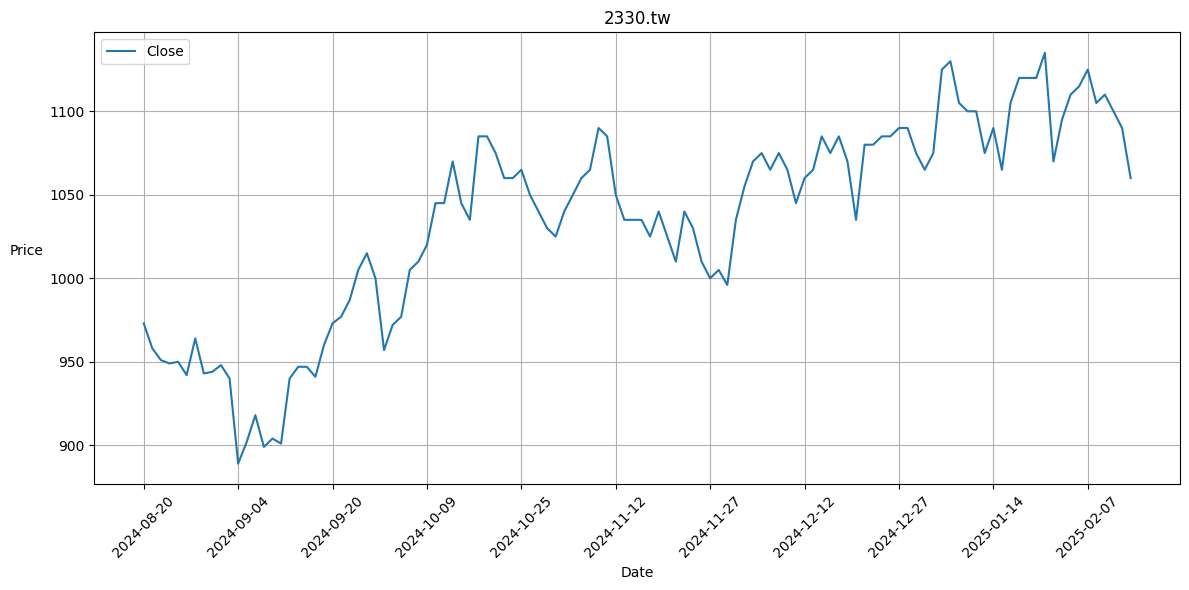

In [18]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 6))

# 設定要繪製的資料欄位
plt.plot(new_df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num], rotation = 45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price', rotation=0, ha='right')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()

# 顯示圖表
plt.show()

### 1️⃣4️⃣ 加入成交量

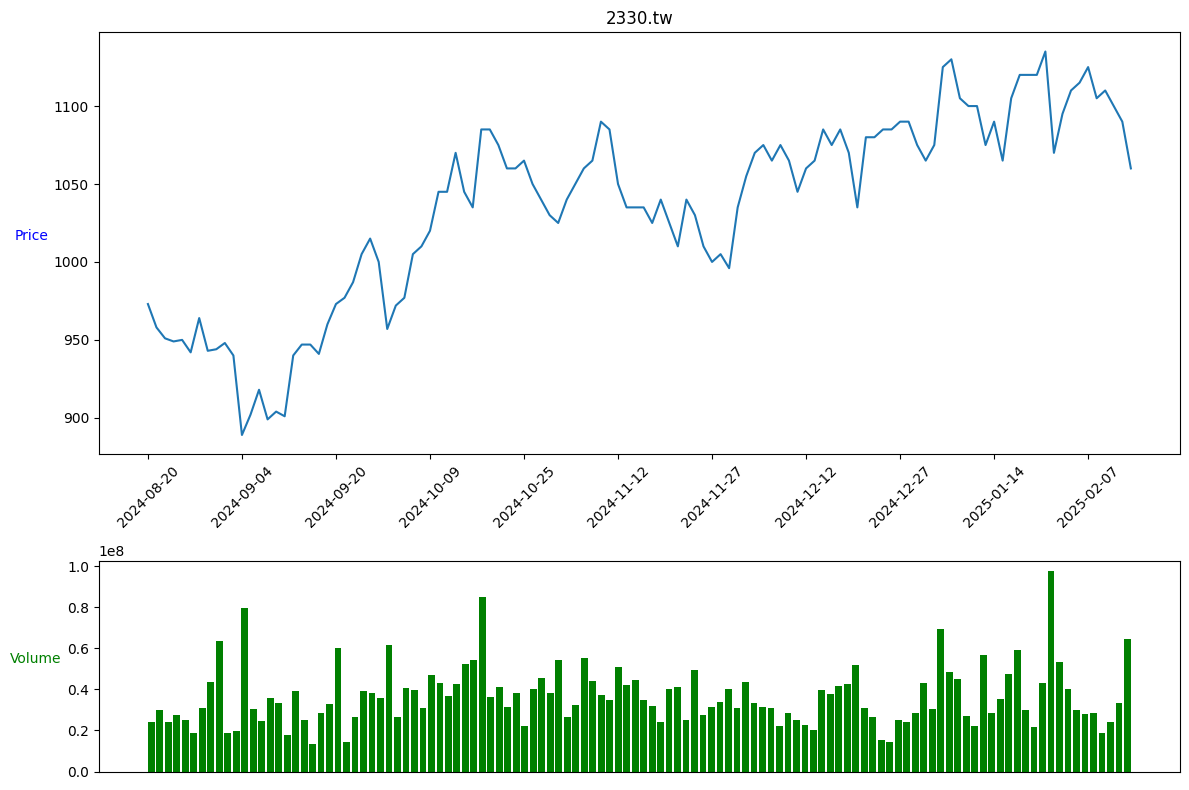

In [19]:
# 創建兩張子圖
fig, (ax1, ax2) = plt.subplots(2, 1,
                figsize=(12, 8),
                gridspec_kw={'height_ratios': [2, 1]})

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num], rotation=45)

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'],  color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')
ax2.set_xticks([]) # 不顯示日期標籤
# 若要顯示圖表標籤可以使用以下程式碼
# ax2.set_xticks(date[::len(date)//num].index)
# ax2.set_xticklabels(date[::len(date)//num], rotation=45)

# 讓子圖填充、對齊
plt.tight_layout()

# 顯示圖表
plt.show()


### 1️⃣5️⃣ 加入技術指標

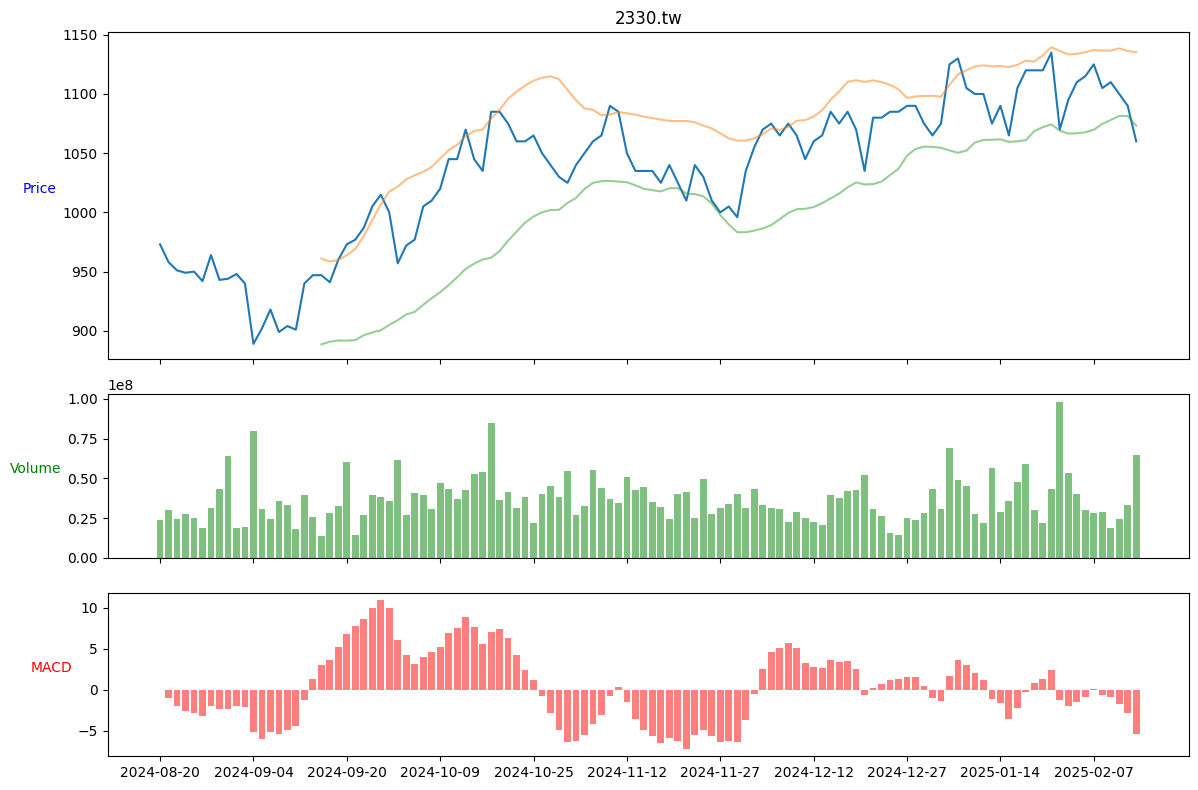

In [20]:
# 創建三個子圖
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                    figsize=(12, 8),
                    gridspec_kw={'height_ratios': [2, 1, 1]},
                    sharex=True)

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
# 加入布林通道
ax1.plot(new_df['Upper_Band'], alpha=0.5) # alpha 設定透明度
ax1.plot(new_df['Lower_Band'], alpha=0.5)
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num])

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'], alpha=0.5, color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')

# 繪製技術指標
ax3.bar(new_df.index, new_df['MACD_Histogram'], alpha=0.5, color='red')
ax3.set_ylabel('MACD', color='red', rotation=0, ha='right')

# 調整子圖間的距離
plt.tight_layout()

# 顯示圖表
plt.show()

### 繪製 K 線圖：mplfinance

### 1️⃣6️⃣ 匯入技術分析繪圖套件

In [21]:
!pip install mplfinance
import mplfinance as mpf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


### 1️⃣7️⃣ 選擇資料時間

In [22]:
kplot_df = new_df.set_index('Date')
kplot_df = kplot_df['2024-02-01':'2024-07-29']
kplot_df.tail()

,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,


### 1️⃣8️⃣ 用 mplfinance 繪製 K 線圖

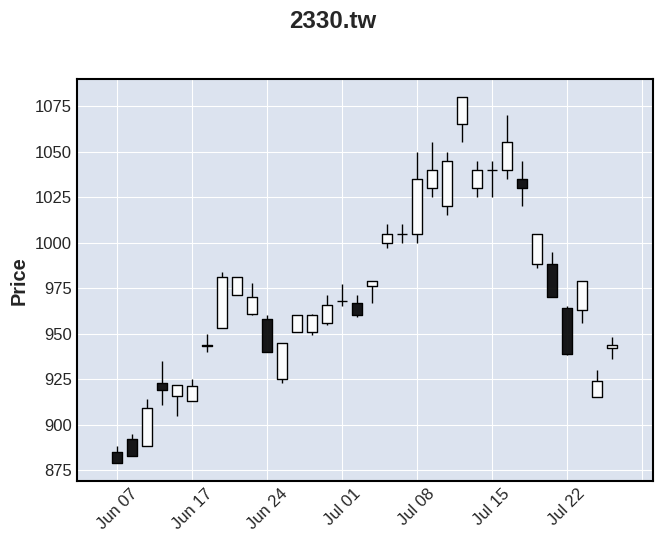

In [ ]:
mpf.plot(kplot_df, type='candle', title=f'{stock_id}')

### 1️⃣9️⃣ 加入繪圖設定

IndexError: index -1 is out of bounds for axis 0 with size 0

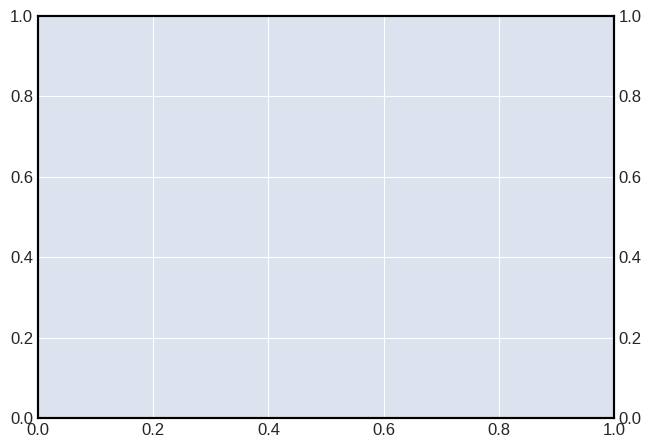

In [27]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)
# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}')

### 2️⃣0️⃣ 加入子圖

IndexError: index -1 is out of bounds for axis 0 with size 0

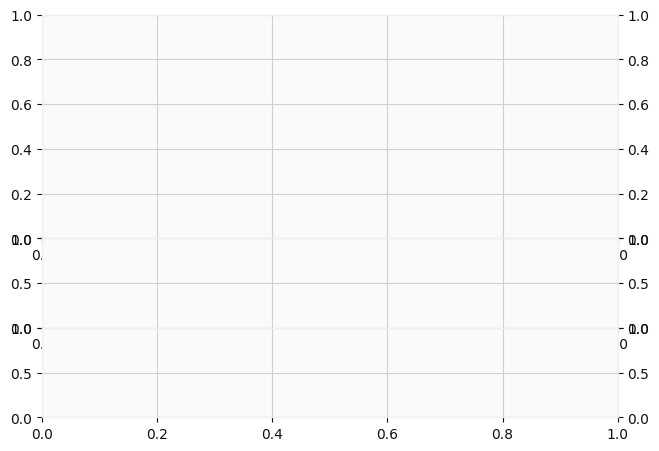

In [28]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo',
                marketcolors=my_color)

# 交易量和技術指標子圖
ap = [
    # 上軌線
    mpf.make_addplot(kplot_df['Upper_Band'], color='red',
                      alpha=0.5, linestyle='--'),
    # 下軌線
    mpf.make_addplot(kplot_df['Lower_Band'], color='red',
                     alpha=0.5, linestyle='--'),
    # 成交量
    mpf.make_addplot(kplot_df['Volume'], panel=1, type='bar',
                     color='g', alpha=0.5, ylabel='Volume'),
    # MACD
    mpf.make_addplot(kplot_df['MACD_Histogram'], panel=2, type='bar',
                     color='r', alpha=0.5, ylabel='MACD')
]

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', addplot=ap,
          style=my_style, title=f'{stock_id}')

## 4-3 plotly 互動式圖表

### 2️⃣1️⃣ 檢視資料

In [29]:
bk_df = new_df
bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')
bk_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA8,MA13,EMA12,EMA26,MACD,Signal,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,
2025-02-10,2025-02-10,1125.0,1125.0,1095.0,1105.0,1105.0,28527108,1109.375,1105.769231,1106.737245,1097.339234,9.398011,10.055749,-0.657738,50.909091,1136.766631,1074.771831,270531986
2025-02-11,2025-02-11,1110.0,1115.0,1100.0,1110.0,1110.0,18898928,1108.125,1107.307692,1107.239207,1098.277068,8.962139,9.837027,-0.874888,56.862745,1136.568318,1078.047067,289430914
2025-02-12,2025-02-12,1110.0,1115.0,1100.0,1100.0,1100.0,24172954,1103.750,1110.000000,1106.125483,1098.404693,7.720790,9.413780,-1.692989,52.000000,1138.530628,1081.469372,265257960
2025-02-13,2025-02-13,1090.0,1095.0,1080.0,1090.0,1090.0,33210403,1106.250,1108.846154,1103.644639,1097.782123,5.862517,8.703527,-2.841010,55.319149,1136.319526,1081.372782,232047557
2025-02-14,2025-02-14,1065.0,1070.0,1060.0,1060.0,1060.0,64486940,1101.875,1104.230769,1096.930080,1094.983447,1.946632,7.352148,-5.405516,40.000000,1135.192333,1073.269206,167560617


### 2️⃣2️⃣ 匯入 plotly 套件

In [30]:
import plotly.graph_objects as go

### 2️⃣3️⃣ 繪製互動式 K 線圖

In [31]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 顯示圖表
fig.show()

### 2️⃣4️⃣ 移除非交易日空值
解決繪圖不連續問題

In [32]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 移除非交易日空值
# 生成該日期範圍內的所有日期
all_dates = pd.date_range(start=bk_df.index.min(),
              end=bk_df.index.max())
# 找出不在資料中的日期
breaks = all_dates[~all_dates.isin(bk_df.index)]
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

# 顯示圖表
fig.show()

<ipython-input-32-11ede7c86549>:21: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣5️⃣ 加入懸停十字軸

In [33]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])


# 圖表更新-加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_layout(
    height=800,
    width=1200
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

<ipython-input-33-28d88b8e0393>:24: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣6️⃣ 加入技術指標

In [34]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red', decreasing_line_color='green',
            name = "K 線")])


# 布林通道
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Upper_Band'],mode='lines',
    line={'color': 'green','dash': 'dash'},name = "上軌線"))
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Lower_Band'], mode='lines',
    line={'color': 'green', 'dash': 'dash'},name = "下軌線"))

# 交易量
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['Volume'], marker={'color': 'green'},
      yaxis='y2', name = "交易量"))

# MACD
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['MACD_Histogram'], marker={'color': 'red'},
      yaxis='y3', name = "MACD"))

# 加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="toaxis")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")

# 更新畫布大小並增加範圍選擇
fig.update_layout(
    height=800,
    yaxis={'domain': [0.35, 1]},
    yaxis2={'domain': [0.15, 0.3]},
    yaxis3={'domain': [0, 0.15]},
    title=f"{stock_id}",
    xaxis={
        # 範圍選擇格
        'rangeselector': {
            'buttons': [
                {'count': 1, 'label': '1M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 6, 'label': '6M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 1, 'label': '1Y',
                  'step': 'year', 'stepmode': 'backward'},
                {'step': 'all'}
            ]
        },
        # 範圍滑動條
        'rangeslider': {
            'visible': True,
            # 滑動條的高度 (設置 0.01 就會變單純的 bar)
            'thickness': 0.01,
            'bgcolor': "#E4E4E4"  # 背景色
        },
        'type': 'date'
    }
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

<ipython-input-34-c4952c4d4546>:69: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣7️⃣ 寫成函式

In [35]:
# 下載資料並讓 AI 計算指標
def download_stock_data(stock_id, start=None,
                        end=None, indicator='MACD'):
    stock_id = f"{stock_id}.tw"
    if not end:
        end = dt.date.today()
    if not start:
        start = end - dt.timedelta(days=365)
    # 從 yf 下載資料
    df = yf.download(stock_id, start=start, end=end).reset_index()

    # AI 計算技術指標
    code_str = ai_helper(df, f"計算{indicator}")
    print(code_str)

    # 將 exec 生成的 calculate 設為局部變數
    local_vars = {}
    exec(code_str, globals(), local_vars)
    calculate = local_vars['calculate']

    df = calculate(df)

    # 資料處理
    bk_df = df.reset_index()
    bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')

    return bk_df

# 繪製圖表函式
def create_stock_figure(stock_id, bk_df):

    # 創建 K 線圖
    fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
                        open=bk_df['Open'],
                        high=bk_df['High'],
                        low=bk_df['Low'],
                        close=bk_df['Close'],
                        increasing_line_color='red',
                        decreasing_line_color='green',
                        name = "K 線")])

    # 交易量
    fig.add_trace(go.Bar(x=bk_df.index, y=bk_df['Volume'],
                         marker={'color': 'green'}, yaxis='y2',
                           name = "交易量"))

    # 找出需要繪製的欄位
    columns = bk_df.columns
    exclude_columns = ['index','Date', 'Open', 'High',
                        'Low', 'Close', 'Adj Close', 'Volume']
    remain_columns = [col for col in columns if
                       col not in exclude_columns]
    min_close = bk_df['Close'].min() - bk_df['Close'].std()
    max_close = bk_df['Close'].max() + bk_df['Close'].std()
    # 繪製技術指標
    for i in remain_columns:
      if min_close <= bk_df[i].mean() <= max_close:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', name=i))
      else:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', yaxis='y3', name=i))

    # 加入懸停十字軸
    fig.update_xaxes(showspikes=True, spikecolor="gray",
                    spikemode="toaxis")
    fig.update_yaxes(showspikes=True, spikecolor="gray",
                    spikemode="across")
    # 更新畫布大小並增加範圍選擇
    fig.update_layout(
        height=800,
        width=1200,
        yaxis={'domain': [0.35, 1]},
        yaxis2={'domain': [0.15, 0.3]},
        # 若要重疊 y1 和 y3, 可以改成
        # yaxis3=dict(overlaying='y', side='right')
        yaxis3={'domain': [0, 0.15]},
        title=f"{stock_id}",
        xaxis={
            # 範圍選擇格
            'rangeselector': {
                'buttons': [
                    {'count': 1, 'label': '1M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 6, 'label': '6M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 1, 'label': '1Y',
                      'step': 'year', 'stepmode': 'backward'},
                    {'step': 'all'}
                ]
            },
            # 範圍滑動條
            'rangeslider': {
                'visible': True,
                'thickness': 0.01,  # 滑動條的高度
                'bgcolor': "#E4E4E4"  # 背景色
            },
            'type': 'date'
        }
    )

    # 移除非交易日空值
    # 生成該日期範圍內的所有日期
    all_dates = pd.date_range(start=bk_df.index.min(),
                               end=bk_df.index.max())
    # 找出不在資料中的日期
    breaks = all_dates[~all_dates.isin(bk_df.index)]
    dt_breaks = breaks.tolist() # 轉換成列表格式
    fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

    return fig

# 主函式
def plotly_stock(stock_id, start=None, end=None, indicator='MACD'):

    df = download_stock_data(stock_id, start, end, indicator)
    fig = create_stock_figure(stock_id,df)
    fig.show()

### 2️⃣8️⃣ 執行函式

In [36]:
plotly_stock("2317", start='2022-01-01', end= None,
             indicator='布林通道及MACD')

[*********************100%%**********************]  1 of 1 completed



 import pandas as pd
 

 def calculate(df):
  # Calculate Moving Average
  df['MA20'] = df['Close'].rolling(window=20).mean()
 

  # Calculate Standard Deviation
  df['STD20'] = df['Close'].rolling(window=20).std()
 

  # Calculate Upper Bollinger Band
  df['Upper'] = df['MA20'] + 2 * df['STD20']
 

  # Calculate Lower Bollinger Band
  df['Lower'] = df['MA20'] - 2 * df['STD20']
 

  # Calculate MACD
  df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
  df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
  df['MACD'] = df['EMA12'] - df['EMA26']
  df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
  df['Histogram'] = df['MACD'] - df['Signal']
 

  return df
 


IndentationError: unexpected indent (<string>, line 2)